In [14]:
#  In this problem we need to identify the digit in given images. We have total 70,000 images, 
#out of which 49,000 are part of train images with the label of digit and rest 21,000 images 
# are unlabeled (known as test images). Now, We need to identify the digit for test images. 
#Public and Private split for test images are 40:60 and evaluation metric of this challenge is accuracy. 

#About Data:

#The data set used for this problem is from the populat MNIST data set. 
# Developed by Yann LeCun, Corina Cortes and Christopher Burger for evaluating machine learning model
# on the handwritten digit classification problem. It is a widely used data set in the machine learning 
# community. For more details about the data set, read here http://bit.ly/1REjJgL

In [15]:
# All the images are 28X28 size and are in .png format 

In [1]:
%pylab inline
import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


/home/sidhraj/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
## Getting the warning: RuntimeWarning: compiletime version 3.5 of module 
#'tensorflow.python.framework.fast_tensor_util' does not match
# runtime version 3.6
# To supress the warning :
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# For reproducing the results, setting the seed
seed = 34
rng = np.random.RandomState(seed)

In [4]:
# Setting up the directories: for data, submission

root_dir = os.path.abspath('/home/sidhraj/Documents/AV/Identify Digits/')
data_dir = os.path.join(root_dir, 'Data')
sub_dir = os.path.join(root_dir, 'Submission')

# check for existence of the directories
os.path.exists(root_dir)
os.path.exists(data_dir)
os.path.exists(sub_dir)

True

In [5]:
## Loading the files

In [7]:
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(data_dir, 'Sample_Submission.csv'))

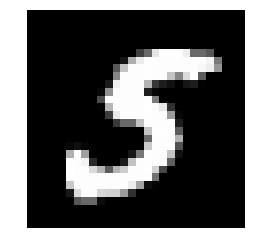

In [8]:
# Just to check how the image looks:

img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'train', img_name)
img = imread(filepath, flatten=True)
pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

In [9]:
img
# internal representation of the above image as numpy array

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.

In [16]:
## Converting the test and train images to numpy array

In [10]:
train_numpy = []
for i in train.filename:  # filename is the ID column in csv file  train
    image_path = os.path.join(data_dir, 'train', i) ## train is the folder containing images
    image = imread(image_path, flatten=True) ## to remove color from images flatten=True
    image = image.astype('float32')
    train_numpy.append(image)
    
train_x = np.stack(train_numpy)

test_numpy = []
for i in test.filename:
    image_path = os.path.join(data_dir, 'test', i)
    image = imread(image_path, flatten=True)
    image = image.astype('float32')
    test_numpy.append(image)
    
test_x = np.stack(test_numpy)

In [12]:
# creating the train and validation set

split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train.label.values[:split_size], train.label.values[split_size:]

In [17]:
## defining function to be used later

In [18]:
# creating one hot encoding
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors"""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot


## normalizing values in batches
def preproc(unclean_batch_x):
    """Convert values to range 0-1"""
    temp_batch = unclean_batch_x / unclean_batch_x.max()
    
    return temp_batch


# creating batches for batch processing

def batch_creator(batch_size, dataset_length, dataset_name):
    """Create batch with random samples and return appropriate format"""
    batch_mask = rng.choice(dataset_length, batch_size)
    
    batch_x = eval(dataset_name + '_x')[[batch_mask]].reshape(-1, input_num_units)
    batch_x = preproc(batch_x)
    
    if dataset_name == 'train':
        batch_y = eval(dataset_name).ix[batch_mask, 'label'].values
        batch_y = dense_to_one_hot(batch_y)
        
    return batch_x, batch_y

In [19]:
# creating a three layer neural network architecture
# input layer : image : 28X28X1, if it would have been a color image : 28X28X3
# output layer : number of classes 10 : vector size of 10x1
# hidden layer : we experiment with different values

In [11]:
input_num_units = 28*28 # input layer
hidden_num_units = 500  # hidden layer
output_num_units = 10 # output layer


# define placeholders
x = tf.placeholder(tf.float32, [None, input_num_units])
y = tf.placeholder(tf.float32, [None, output_num_units])

# set remaining variables
epochs = 5
batch_size = 128
learning_rate = 0.01

### define weights and biases of the neural network

weights = {
    'hidden': tf.Variable(tf.random_normal([input_num_units, hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([hidden_num_units, output_num_units], seed=seed))
}

biases = {
    'hidden': tf.Variable(tf.random_normal([hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([output_num_units], seed=seed))
}

In [13]:
# neural network computational graph

hidden_layer = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
hidden_layer = tf.nn.relu(hidden_layer)

output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']

In [23]:
# cost of neural network 
#                             labels = True labels                             outpoutput_layer    y
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = output_layer ))

# set the optimizer, i.e. backpropogation algorithm. 

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# initialize all the variables
init = tf.global_variables_initializer()

In [26]:
with tf.Session() as sess:
    # create initialized variables
    sess.run(init)
    ## pseudo code for whatever is happening inside the for loop
    ### for each epoch, do:
    ###   for each batch, do:
    ###     create pre-processed batch
    ###     run optimizer by feeding batch
    ###     find cost and reiterate to minimize
    
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = int(train.shape[0]/batch_size)
        for i in range(total_batch):
            batch_x, batch_y = batch_creator(batch_size, train_x.shape[0], 'train')
            _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})
            
            avg_cost += c / total_batch
            
        print ("Epoch:", (epoch+1), "cost =", "{:.5f}".format(avg_cost))
    
    print ("\nTraining complete!")
    
    
    # find predictions on val set
    pred_temp = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(pred_temp, "float"))
    print ("Validation Accuracy:", accuracy.eval({x: val_x.reshape(-1, input_num_units), y: dense_to_one_hot(val_y)}))
    
    predict = tf.argmax(output_layer, 1)
    pred = predict.eval({x: test_x.reshape(-1, input_num_units)})

/home/sidhraj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Epoch: 1 cost = 8.39229
Epoch: 2 cost = 1.73185
Epoch: 3 cost = 0.92921
Epoch: 4 cost = 0.60320
Epoch: 5 cost = 0.39541

Training complete!
Validation Accuracy: 0.956939


In [29]:
import csv
csvfile = "/home/sidhraj/Documents/AV/Identify Digits/Submission/TF1.csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in pred:
        writer.writerow([val])

In [ ]:
## this model gave approx 96 % accuracy on test data